In [15]:
# load and process data
import os,gc
# import sys
from importlib import reload
import torch
import numpy as np
# import matplotlib.pyplot as plt

from wbtool.show import wshow
from wbtool import file_misc as fm
import proc_data,aux

# vid = np.load('/home/wb/samba_dir/cells_brightfield/leadingcell-WB-entirespan/B1ROI1.npy')
# vid = np.load('/home/wb/samba_dir/cells_brightfield/leading-HELA-entirespan/A1ROI1.npy')
vid = np.load('/home/wb/samba_dir/cells_brightfield/single-cell-movement-for-machine-learning/A549/0/A4ROI1.npy')
# vid = vid[:2]

vid = proc_data.value_modify(vid)
vid = proc_data.ch_num_modify(vid)
# print(vid.shape)

# ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/leadingcell-WB-entirespan/Results_B1ROI1.csv')
# ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/leading-HELA-entirespan/Results_A1ROI1.csv')
ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/single-cell-movement-for-machine-learning/A549/0/Results_A4ROI1.csv')


# output masks
output_dir = '/home/wb/samba_dir/indev/results' #io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

(904, 1224, 3)


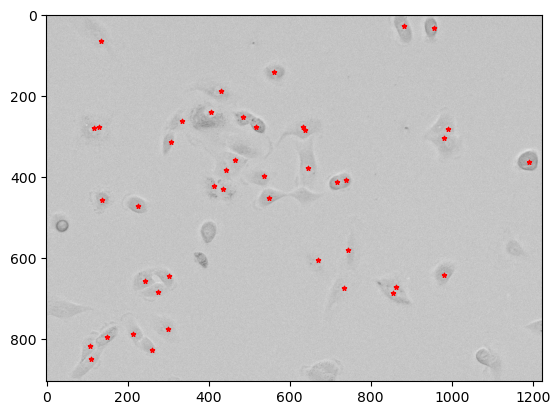

In [6]:
from wbtool import show 

fid = 18
point_prompt = coords[fid]
obj_mode = np.ones((len(point_prompt), 1))
frame = vid[fid]
frame = proc_data.value_modify(frame)
print(frame.shape)

show.overlay_point(frame, point_prompt)

In [16]:
# for segmentation
# reload(aux)
from wbtool import use_models
# from model_args import aot_args,sam_args,segtracker_args
# print(sam_args)
# sam_args['generator_args'] = {
#         'points_per_side': 30,
#         'pred_iou_thresh': 0.8,
#         'stability_score_thresh': 0.9,
#         'crop_n_layers': 1,
#         'crop_n_points_downscale_factor': 2,
#         'min_mask_region_area': 200,
#     }

segtracker_args = {
    'sam_gap': 1, # the interval to run sam to segment new objects
    'min_area': 20, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
    'new_replace_iou_min': 0.5,
    'remain_remove_max':0.4,
    'min_obj_area_ratio':0.0001,
    'max_obj_area_ratio':0.01
}

# SA = use_models.cv.sam_agent('prompt')

# === get segmentation results of each frame.
# (this is independent of tracking activity)
# seg_list = fm.pload(os.path.join(output_dir,'../sms2.pk'))
seg_list = aux.do_segment(SA, segtracker_args, vid, ids, coords)
# fm.pdump(os.path.join(output_dir,'../sms2.pk'), seg_list)


segment for frame 30
-segmentation done


In [18]:
### Generate Results for the Whole Video
import SegTracker
from model_args import aot_args,sam_args
# importlib.reload(SegTracker)
from skimage import morphology
from onevision import morphology as ovmorph
from onevision import morph_proc

# reload(aux)
# reload(proc_data)
# reload(morph_proc)
# reload(ovmorph)

segtracker_args = {
    'sam_gap': 1, # the interval to run sam to segment new objects
    'min_area': 20, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
    'new_replace_iou_min': 0.5,
    'remain_remove_max':0.4,
    'min_obj_area_ratio':0.0001,
    'max_obj_area_ratio':0.01
}

# grounding_caption = "cell"
# box_threshold, text_threshold, box_size_threshold, reset_image = 0.02, 0.02, 0.05, True

# === tracking
segtracker = SegTracker.SegTracker(segtracker_args, sam_args, aot_args)
segtracker.restart_tracker()   # 调用的是aot_tracker/AOTTracker function, AOT模型自身的restart要求.
fnum = len(vid)

torch.cuda.empty_cache()
gc.collect()
pred_list = []; track_list = []; sm2=[]; sm1=[]
# with torch.cuda.amp.autocast():
for frame_idx in range(fnum):
    frame = vid[frame_idx]
    track_list.append(None)
    if frame_idx == 0:
        # print(segtracker.curr_idx)
        pred_mask = morph_proc.imbind_to_map(seg_list[frame_idx])
        segtracker.add_reference(frame, pred_mask)
    elif (frame_idx % segtracker_args['sam_gap']) == 0:
        # 1/2
        seg_mask = seg_list[frame_idx]
        # 2/2
        # seg_mask,_ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
        # e/2

        # torch.cuda.empty_cache()
        # gc.collect()
        track_mask = segtracker.track(frame)
        # wshow(track_mask)
        sm1.append(track_mask)
        track_mask = ovmorph.IMbind(track_mask, 'map')
        print('after track ', track_mask.ids)
        track_mask = aux.isolate_filter_object(track_mask, segtracker_args)
        track_list[frame_idx] = track_mask
        print('before st ', track_mask.ids)
        pred_mask = aux.merge_st(segtracker_args, track_mask, seg_mask)
        print('after st ', pred_mask)
        pred_list.append(pred_mask)
        pred_mask = morph_proc.imbind_to_map(pred_mask)
        print('merged ', list(np.unique(pred_mask)))
        sm2.append(pred_mask)
        # wshow(pred_mask)
        # segtracker.restart_tracker()
        segtracker.add_reference(frame, pred_mask)
    else:
        pred_mask = segtracker.track(frame, update_memory=True)
    # pred_list.append(pred_mask)
    # gc.collect()
    proc_data.save_prediction(pred_mask, output_dir, str(frame_idx)+'.png', opt='overlay', image=frame)    
    print("processed frame {}, obj_num {}".format(frame_idx, segtracker.get_obj_num()))#, end='\r')
print('\n-forward tracking finished')
# fm.pdump(os.path.join(output_dir,'../tms.pk'), track_list)
# fm.pdump(os.path.join(output_dir,'../pms.pk'), pred_list)

# == backward merge part.
# for frame_idx in range(fnum-2, -1, -1):
#     print(frame_idx)
#     frame = vid[frame_idx]

#     if (frame_idx % segtracker_args['sam_gap']) == 0:
#         # 1/2
#         seg_mask = pred_list[frame_idx]
#         # 2/2
#         # seg_mask,_ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
#         # e/2

#         # torch.cuda.empty_cache()
#         # gc.collect()
#         track_mask = segtracker.track(frame)
#         track_mask = aux.isolate_filter_object(track_mask, segtracker_args)
#         track_list[frame_idx] = track_mask
#         pred_mask = aux.merge_st(segtracker_args, track_mask, seg_mask)

#         # segtracker.restart_tracker()
#         segtracker.add_reference(frame, pred_mask)
#     else:
#         pass

#     proc_data.save_prediction(pred_mask, output_dir, str(frame_idx)+'.png')    
#     print("processed frame {}, obj_num {}".format(frame_idx, segtracker.get_obj_num()), end='\r')
# print('\n-backward tracking finished')


/home/wb/apps/miniconda3/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased
Model loaded from /home/wb/tools/Segment-and-Track-Anything/ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43]
dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43])
processed frame 0, obj_num 43
after track  (1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 15, 17, 19, 21, 23, 24, 26, 28, 29, 30, 33, 36, 38, 39, 40, 42, 43)
before st  (1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 13, 15, 17, 19, 21, 23, 24, 26, 28, 29, 30, 33, 36, 38, 39, 40, 42, 43)
7 new
9 new
14 new
16 new
18 new
20 new
22 new
25 new
27 new
31 new
32 new
34 new
35 new
most overlap not 36 but 1
37

In [ ]:
# proc_data.all2imgfile(seg_list, 'ns')
reload(ovmorph)

In [17]:
def expe(imbs):
    fnum = len(imbs)
    onum = 45
    SA = []
    for oi in range(1, onum+1):
        S = []
        for fi in range(fnum):
            if oi in imbs[fi].ids:
                area = np.sum(imbs[fi][oi])
            else:
                area = 0
            S.append(area)
        SA.append(S)
    return SA

31
<class 'onevision.morphology.IMbind'>
IMbind with 43 obj with ids (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43)
image shape:(904, 1224)


供参考的SegTracker函数

刘平版：
def detect_and_seg_pt(self, origin_frame: np.ndarray, coords, modes):
    '''
    Using Grounding-DINO to detect object acc Text-prompts
    Retrun:
        refined_merged_mask: numpy array (h, w)
        annotated_frame: numpy array (h, w, 3)
    '''
            # backup id and origin-merged-mask
    bc_id = self.curr_idx
    bc_mask = self.origin_merged_mask
    
    # get annotated_frame and boxes
    # annotated_frame, boxes = self.detector.run_grounding(origin_frame, grounding_caption, box_threshold, text_threshold)
    for i in range(len(coords)):
        pt = coords[i].reshape([1,2])
        mode = modes[i]
        # if (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]) > annotated_frame.shape[0] * annotated_frame.shape[1] * box_size_threshold:
        #     continue
        interactive_mask = self.sam.segment_with_click(origin_frame, pt, mode)

        mask = interactive_mask.copy()
        if(mask.sum(1).sum(0)/(mask.shape[0]*mask.shape[1]) < 0.01): 
            refined_merged_mask = self.add_mask(interactive_mask)
            self.update_origin_merged_mask(refined_merged_mask)
            self.curr_idx += 1

    # reset origin_mask
    self.reset_origin_merged_mask(bc_mask, bc_id)

    return refined_merged_mask

最终版：
    def detect_and_seg_pt(self, frame: np.ndarray, coords, modes):
        '''
        Using Grounding-DINO to detect object acc Text-prompts
        Retrun:
            refined_merged_mask: numpy array (h, w)
            annotated_frame: numpy array (h, w, 3)
        '''
        # backup id and origin-merged-mask
        bc_id = self.curr_idx
        bc_mask = self.origin_merged_mask
    
        # get annotated_frame and boxes
        # annotated_frame, boxes = self.detector.run_grounding(frame, grounding_caption, box_threshold, text_threshold)
        cnum = len(coords)
        imgarea = frame.shape[0]*frame.shape[1]
        # ims = []
        refined_merged_mask = self.add_mask(np.zeros(frame.shape[:2], dtype=np.uint8))
        for k in range(cnum):
            # if (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]) > annotated_frame.shape[0] * annotated_frame.shape[1] * box_size_threshold:
            #     continue
            interactive_mask = self.sam.segment_with_click(frame, coords[k:k+1], modes[k], True)
            # ims.append(interactive_mask.copy())
            
            if interactive_mask.sum(1).sum(0)/imgarea < 0.01:
                refined_merged_mask = self.add_mask(interactive_mask)  #在self.origin_merged_mask 的基础上，根据输入修改得到返回值。
                self.update_origin_merged_mask(refined_merged_mask)
                self.curr_idx += 1

        # reset origin_mask
        self.reset_origin_merged_mask(bc_mask, bc_id)

        return refined_merged_mask